## DengAI competition
The goal of this competition is to build a model that predicts the number of Dengue cases in San Juan and Iquitos

- [X] Create a time split 80 - 20 per city (there are more years to train and predict for sj than iq)
- [X] Create a basic baseline model with all features 'as is' (bad performance expected)
- [X] Create a basic model only non-correlated features
- [X] One model per city
- [X] Normalize features
- [X] Obtain feature importance
- [X] Implement time delay using moving averages
- [X] Test multiple models

In [65]:
import pandas as pd
import os
import seaborn as sns
from dateutil import parser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
tqdm.pandas()
import numpy as np
import hydra
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import lightgbm as lgb

### Load data

In [38]:
data_folder = 'data'
features_train_path = 'dengue_features_train.csv'
labels_train_path = 'dengue_labels_train.csv'
features_test_path = 'dengue_features_test.csv'

In [39]:
features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
features_test = pd.read_csv(os.path.join(data_folder, features_test_path))

### Basic Pre-processing

In [40]:
# transform week_start_date into a datetime feature
features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)

  0%|          | 0/1456 [00:00<?, ?it/s]

In [41]:
# Merge features and labels for easier exploration
train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])

In [42]:
def fill_ma(df, col):
    df[col+'_MA'] =  df[col].fillna(df[col].mean()).rolling(2).mean().tolist()
    df[col] = df.apply(lambda x: x[col] if not np.isnan(x[col]) else x[col+'_MA'], axis=1)
    df.drop(columns=[col+'_MA'], inplace=True)

In [43]:
fill_ma_cols = [col for col in train_df.columns if train_df[train_df[col].isna()].shape[0] > 0]
for col in tqdm(fill_ma_cols):
#     fill_ma(train_df, col)
    train_df[col].fillna(method='ffill', inplace=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)

In [45]:
train_df.sort_values(by=['city', 'year', 'weekofyear'], ascending=[0,1,1])#, inplace=True)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [46]:
for col in list(train_df.select_dtypes(include=np.number).columns):
    if col not in ["year", "weekofyear", "total_cases"]:
        print(col)
        train_df[col + "_SHIFT"] = train_df.groupby("city")[col].shift(20).fillna(train_df[col].mean())
        train_df[col + "_MA"] = train_df[col].rolling(20).mean().fillna(train_df[col].mean())

ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm


<AxesSubplot:xlabel='weekofyear', ylabel='station_avg_temp_c'>

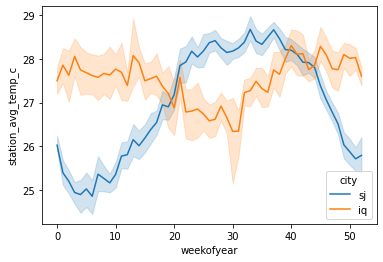

In [47]:
sns.lineplot(x='weekofyear', y='station_avg_temp_c', hue='city', data= train_df)

<AxesSubplot:xlabel='weekofyear', ylabel='station_avg_temp_c_MA'>

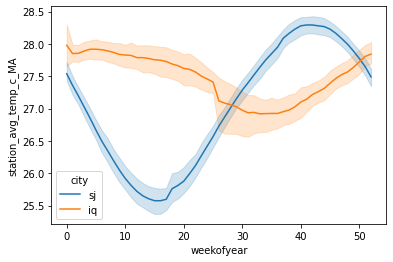

In [48]:
sns.lineplot(x='weekofyear', y='station_avg_temp_c_MA', hue='city', data= train_df)

<AxesSubplot:xlabel='weekofyear', ylabel='station_avg_temp_c_SHIFT'>

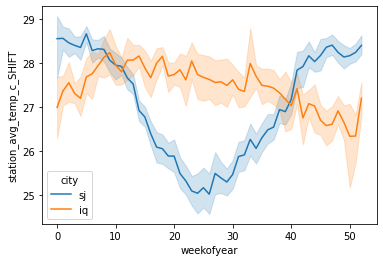

In [49]:
sns.lineplot(x='weekofyear', y='station_avg_temp_c_SHIFT', hue='city', data= train_df)

<AxesSubplot:xlabel='weekofyear', ylabel='total_cases'>

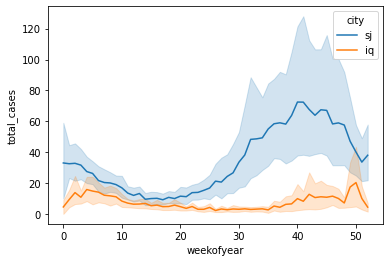

In [50]:
sns.lineplot(x='weekofyear', y='total_cases', hue='city', data= train_df)

### Split train - eval

In [51]:
iq_train_years = sorted(train_df[train_df.city == 'iq']['year'].drop_duplicates().values)[:int(train_df[train_df.city == 'iq']['year'].nunique() * 0.8)]
iq_eval_years = sorted(train_df[train_df.city == 'iq']['year'].drop_duplicates().values)[int(train_df[train_df.city == 'iq']['year'].nunique() * 0.8):]
sj_train_years = sorted(train_df[train_df.city == 'sj']['year'].drop_duplicates().values)[:int(train_df[train_df.city == 'sj']['year'].nunique() * 0.8)]
sj_eval_years = sorted(train_df[train_df.city == 'sj']['year'].drop_duplicates().values)[int(train_df[train_df.city == 'sj']['year'].nunique() * 0.8):]

In [52]:
eval_df = train_df[((train_df.city == 'sj') & (train_df.year.isin(sj_eval_years))) | ((train_df.city == 'iq') & (train_df.year.isin(iq_eval_years)))]
train_df = train_df[((train_df.city == 'sj') & (train_df.year.isin(sj_train_years))) | ((train_df.city == 'iq') & (train_df.year.isin(iq_train_years)))]

In [53]:
eval_df.shape

(303, 65)

In [54]:
train_df.shape

(1153, 65)

### Only non-correlated features

In [55]:
initial_list = [
    'weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [56]:
final_list = []
for col in initial_list:
    final_list.append(col)
    if col not in ['total_cases', 'weekofyear']:
        final_list.append(col + '_MA')
        final_list.append(col + '_SHIFT')
initial_list = final_list

In [57]:
initial_list

['weekofyear',
 'ndvi_ne',
 'ndvi_ne_MA',
 'ndvi_ne_SHIFT',
 'ndvi_nw',
 'ndvi_nw_MA',
 'ndvi_nw_SHIFT',
 'ndvi_se',
 'ndvi_se_MA',
 'ndvi_se_SHIFT',
 'ndvi_sw',
 'ndvi_sw_MA',
 'ndvi_sw_SHIFT',
 'precipitation_amt_mm',
 'precipitation_amt_mm_MA',
 'precipitation_amt_mm_SHIFT',
 'reanalysis_air_temp_k',
 'reanalysis_air_temp_k_MA',
 'reanalysis_air_temp_k_SHIFT',
 'reanalysis_avg_temp_k',
 'reanalysis_avg_temp_k_MA',
 'reanalysis_avg_temp_k_SHIFT',
 'reanalysis_dew_point_temp_k',
 'reanalysis_dew_point_temp_k_MA',
 'reanalysis_dew_point_temp_k_SHIFT',
 'reanalysis_max_air_temp_k',
 'reanalysis_max_air_temp_k_MA',
 'reanalysis_max_air_temp_k_SHIFT',
 'reanalysis_min_air_temp_k',
 'reanalysis_min_air_temp_k_MA',
 'reanalysis_min_air_temp_k_SHIFT',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_precip_amt_kg_per_m2_MA',
 'reanalysis_precip_amt_kg_per_m2_SHIFT',
 'reanalysis_relative_humidity_percent',
 'reanalysis_relative_humidity_percent_MA',
 'reanalysis_relative_humidity_percent_SHI

In [58]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [59]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
feature_names = list(features_train.columns)
features_train = features_train.values
label_train = train_df[TARGET].values
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols])).values
label_eval = eval_df[TARGET].values

In [60]:
scaler = 'sklearn.preprocessing.StandardScaler'
scaler = hydra.utils.get_class(scaler)()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_eval = scaler.transform(features_eval)

In [61]:
model = 'sklearn.neural_network.MLPRegressor'
clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,2,), early_stopping=True, random_state = 5)
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


18.706115396124222

In [62]:
model = 'sklearn.svm.SVR'
clf = hydra.utils.get_class(model)(kernel="linear")
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

13.810583396580114

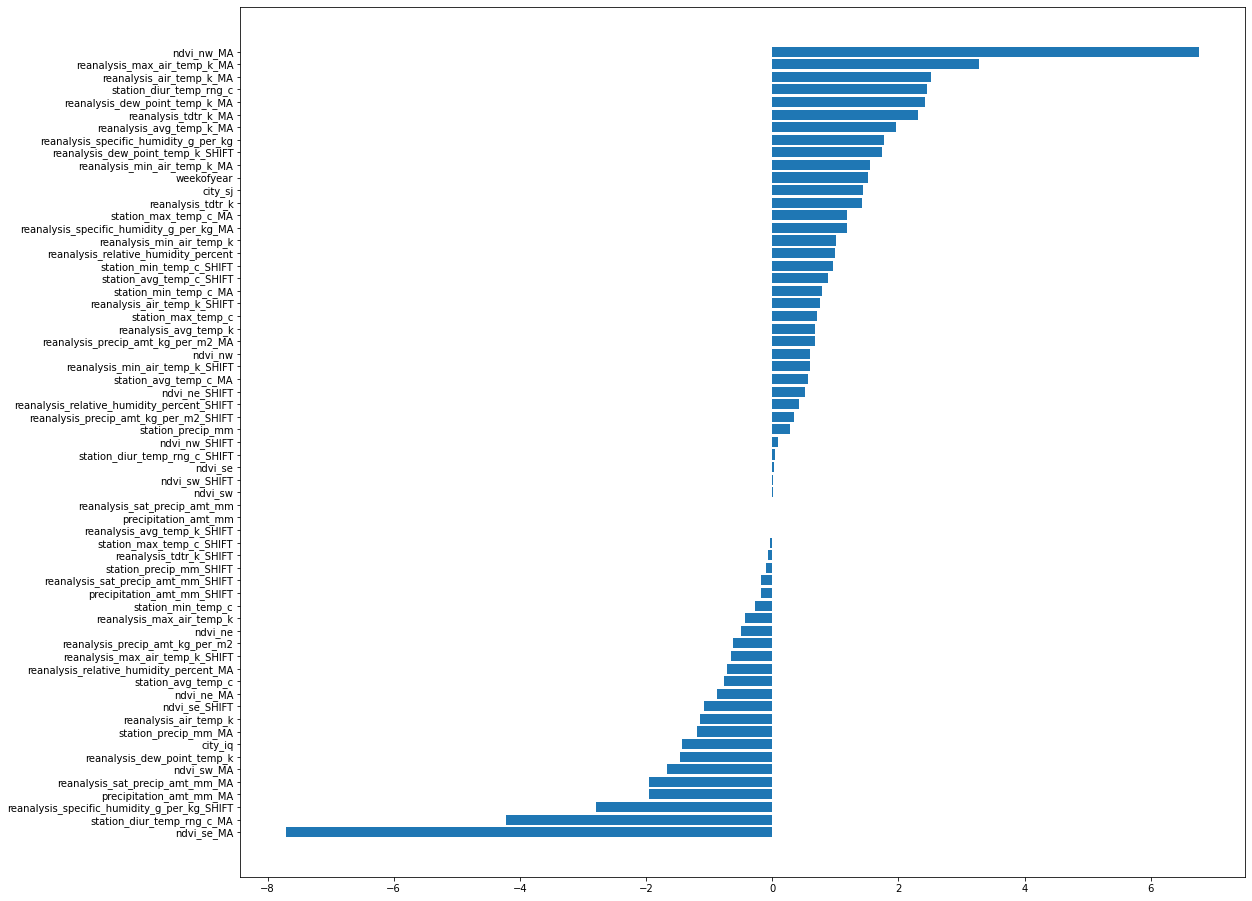

In [67]:
def f_importances(coef, names):
    figure(figsize=(18, 16))
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(clf.coef_[0], feature_names)

In [27]:
model = 'sklearn.svm.SVR'
clf = hydra.utils.get_class(model)()
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

13.530791276855572

In [28]:
model = 'sklearn.tree.DecisionTreeRegressor'
clf = hydra.utils.get_class(model)(random_state=5)
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

15.762376237623762

In [29]:
model = 'sklearn.ensemble.RandomForestRegressor'
clf = hydra.utils.get_class(model)(random_state=5)
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

15.10062706270627

In [30]:
model = 'sklearn.linear_model.PassiveAggressiveRegressor'
clf = hydra.utils.get_class(model)(random_state=5)
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

16.809592509403636

In [31]:
model = 'sklearn.linear_model.SGDRegressor'
clf = hydra.utils.get_class(model)(random_state=5)
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

20.776890722715336

In [32]:
model = 'sklearn.gaussian_process.GaussianProcessRegressor'
clf = hydra.utils.get_class(model)(random_state=5)
clf = clf.fit(features_train, label_train)
y_hat = clf.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

14.74484722699696

In [33]:
lgbm = lgb.LGBMRegressor()
lgbm = lgbm.fit(features_train, label_train)
y_hat = lgbm.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

15.830672608848559

In [34]:
lgb_train = lgb.Dataset(features_train, label_train)
lgb_val = lgb.Dataset(features_eval, label_eval)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'learning_rate': 0.001 ,
    'verbose': 0,
    'num_leaves': 21,
    'max_bin': 21,
    'verbose': 0,
    'num_rounds': 20000,
}

In [35]:
lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=10,early_stopping_rounds=50) 

c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\basla\documents\projects\dengai\dengai\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 762.592	valid_0's l1: 21.1252
[20]	valid_0's l2: 755.413	valid_0's l1: 21.0287
[30]	valid_0's l2: 748.467	valid_0's l1: 20.9353
[40]	valid_0's l2: 741.713	valid_0's l1: 20.8428
[50]	valid_0's l2: 735.114	valid_0's l1: 20.7501
[60]	valid_0's l2: 728.682	valid_0's l1: 20.6595
[70]	valid_0's l2: 722.422	valid_0's l1: 20.5701
[80]	valid_0's l2: 716.275	valid_0's l1: 20.4808
[90]	valid_0's l2: 710.332	valid_0's l1: 20.3943
[100]	valid_0's l2: 704.584	valid_0's l1: 20.3094
[110]	valid_0's l2: 698.976	valid_0's l1: 20.2256
[120]	valid_0's l2: 693.501	valid_0's l1: 20.1426
[130]	valid_0's l2: 688.169	valid_0's l1: 20.0582
[140]	valid_0's l2: 682.819	valid_0's l1: 19.971
[150]	valid_0's l2: 677.612	valid_0's l1: 19.885
[160]	valid_0's l2: 672.484	valid_0

[1740]	valid_0's l2: 458.312	valid_0's l1: 14.1221
[1750]	valid_0's l2: 458.222	valid_0's l1: 14.1107
[1760]	valid_0's l2: 457.974	valid_0's l1: 14.0977
[1770]	valid_0's l2: 456.481	valid_0's l1: 14.0728
[1780]	valid_0's l2: 454.952	valid_0's l1: 14.0517
[1790]	valid_0's l2: 453.635	valid_0's l1: 14.0388
[1800]	valid_0's l2: 452.34	valid_0's l1: 14.025
[1810]	valid_0's l2: 451.094	valid_0's l1: 14.0117
[1820]	valid_0's l2: 449.971	valid_0's l1: 14.0007
[1830]	valid_0's l2: 448.859	valid_0's l1: 13.9886
[1840]	valid_0's l2: 447.934	valid_0's l1: 13.977
[1850]	valid_0's l2: 446.866	valid_0's l1: 13.9647
[1860]	valid_0's l2: 445.947	valid_0's l1: 13.9521
[1870]	valid_0's l2: 445.72	valid_0's l1: 13.953
[1880]	valid_0's l2: 445.774	valid_0's l1: 13.9577
[1890]	valid_0's l2: 445.739	valid_0's l1: 13.961
[1900]	valid_0's l2: 445.842	valid_0's l1: 13.9658
[1910]	valid_0's l2: 445.861	valid_0's l1: 13.9695
Early stopping, best iteration is:
[1862]	valid_0's l2: 445.756	valid_0's l1: 13.9498


In [36]:
y_hat =  lgbm_model.predict(features_eval)
mean_absolute_error(label_eval, y_hat)

13.949842416027693

SVR looks like the best model so far, but LigtGBM is also showing some potential